In [1]:
# %%
%load_ext autoreload
%autoreload 2
#%%
import os
from os.path import join
import re
import math
import pickle as pkl
import time
import glob
from PIL import Image
import numpy as np
import pandas as pd
from easydict import EasyDict as edict
import h5py
import seaborn as sns
import matplotlib.pyplot as plt
from neuro_data_analysis.mat_data_translate_lib import h5_to_dict_simplify, print_hdf5_info
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from core.utils.plot_utils import saveallforms
from core.utils.colormap_matlab import parula, viridis

# set the pandas display options width
pd.set_option('display.width', 1000)
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

mat_root = r"S:\Data-Ephys-MAT"
pkl_root = r"S:\Data-Ephys-PKL"
exp_record_pathdict = {"Alfa": r"S:\Exp_Record_Alfa.xlsx", 
                       "Beto": r"S:\ExpSpecTable_Augment.xlsx",
                       "Caos": r"S:\Exp_Record_Caos.xlsx",
                       "Diablito": r"S:\Exp_Record_Diablito.xlsx"}

#%% Main analysis pipeline
from neuro_data_analysis.neural_tuning_analysis_lib import organize_unit_info, maybe_add_unit_id_to_meta, \
    calculate_neural_responses, parse_stim_info, find_full_image_paths, load_space_images
from core.utils.montage_utils import PIL_array_to_montage, PIL_array_to_montage_score_frame
from core.utils.dataset_utils import ImagePathDataset
from tqdm.auto import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\ponce\.conda\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
ExpRecord_Hessian_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_tuning_ABCD_w_meta.csv")
ExpRecord_Evol_All = pd.read_csv(r"ExpRecord_BigGAN_Hessian_Evol_ABCD_w_meta.csv")
figroot = f"E:\OneDrive - Harvard University\BigGAN_Hessian"
tuning_stats_synopsis = []
# ExpRecord_Hessian_All = ExpRecord_Hessian_All.sort_values(by=["Animal", "Expi"]).reset_index(drop=True)
for rowi, exprow in tqdm(ExpRecord_Hessian_All.iterrows()):
    print("Processing: row", rowi, exprow.ephysFN, exprow.Animal, exprow.Expi)
    figdir = join(figroot, exprow.ephysFN)
    os.makedirs(figdir, exist_ok=True)
    
    # Load data
    data = pkl.load(open(join(pkl_root, f"{exprow.ephysFN}.pkl"), "rb"))
    rasters = data["rasters"]
    meta = data["meta"]
    Trials = data["Trials"]
    stimuli_dir = exprow.stimuli
    imageName = np.squeeze(Trials.imageName)
    # Process unit information
    meta = maybe_add_unit_id_to_meta(meta, rasters,) # for older experiments, unit_id is not in the meta file
    unit_info = organize_unit_info(meta, exprow)
    prefchan_id = unit_info["prefchan_id"]
    prefchan_str = unit_info["prefchan_str"]
    expstr = f"{exprow.ephysFN} | Pref Channel {prefchan_str}"
    
    # Process image names
    unique_imgnames = np.unique(imageName)
    stim_info_df = parse_stim_info(unique_imgnames)
    indices_per_name = {name: np.where(imageName == name)[0] for name in unique_imgnames}
    stim_info_df["trial_ids"] = stim_info_df.apply(lambda row: indices_per_name[row["img_name"]], axis=1)
    uniq_img_fps = find_full_image_paths(stimuli_dir, unique_imgnames)
    
    # make the image dataset
    # stimuli_dataset = ImagePathDataset(list(uniq_img_fps.values()), scores=None, img_dim=(256, 256))

    # Calculate responses
    resp_info = calculate_neural_responses(rasters, prefchan_id)
    prefchan_resp_sgtr = resp_info["prefchan_resp_sgtr"]
    prefchan_bsl_mean = resp_info["prefchan_bsl_mean"]
    prefchan_bsl_sem = resp_info["prefchan_bsl_sem"]
    
    # Create response dataframe
    sgtr_resp_df = pd.DataFrame({"img_name": imageName, "pref_unit_resp": prefchan_resp_sgtr[:, 0]})
    # drop the index as trial_id
    sgtr_resp_df["trial_id"] = sgtr_resp_df.index
    # annotate the response dataframe with the stimulus information by merging on the image name
    sgtr_resp_df = sgtr_resp_df.merge(stim_info_df.drop(columns=['trial_ids']), on="img_name")
    # compute the average response per space and eigenvector
    pref_avgresp_df = sgtr_resp_df.groupby(['space_name', 'eig_id', 'lin_dist']).agg({'pref_unit_resp': 'mean'}).reset_index()
    pref_avg_resp_class = pref_avgresp_df.query(f"space_name == 'class'")
    pref_avg_resp_noise = pref_avgresp_df.query(f"space_name == 'noise'")
    pref_avg_resp_noise_mat = pref_avg_resp_noise.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
    pref_avg_resp_class_mat = pref_avg_resp_class.pivot(index='eig_id', columns='lin_dist', values='pref_unit_resp')
    # origin stats 
    sgtr_resp_at_origin = sgtr_resp_df.query(f"lin_dist == 0.0")
    tuning_stats_col = []
    for space in ["class", "noise"]:
        sgtr_resp_per_space = sgtr_resp_df.query(f"space_name == '{space}'")
        unique_eig_ids = sorted(sgtr_resp_per_space['eig_id'].unique())
        num_eig_ids = len(unique_eig_ids)
        # collect the info for lin_dist == 0 
        for i, eig_id in enumerate(unique_eig_ids):
            subset = sgtr_resp_per_space[sgtr_resp_per_space['eig_id'] == eig_id]
            unique_lin_dists = sorted(subset.lin_dist.unique())
            if 0.0 not in unique_lin_dists:
                # if 0.0 not in this set, augment the subset with the origin stats. 
                # TODO: design decision, augment only with the origin stats with this space or both space. 
                subset = pd.concat([subset, sgtr_resp_at_origin.query(f"space_name == '{space}'")])
                unique_lin_dists = sorted(subset.lin_dist.unique())
                # raise ValueError(f"unique_lin_dists: {unique_lin_dists}")
            F_value = None
            p_value = None
            stats_str = ""
            if len(unique_lin_dists) > 1:
                # Perform ANOVA, only if there are more than 1 data point
                try:
                    model = ols('pref_unit_resp ~ C(lin_dist)', data=subset).fit()
                    anova_table = sm.stats.anova_lm(model, typ=2)
                    F_value = anova_table.loc['C(lin_dist)', 'F']
                    p_value = anova_table.loc['C(lin_dist)', 'PR(>F)']
                    stats_str = f"F-val: {F_value:.2f} | p-val: {p_value:.1e}"
                except Exception as e:
                    print(f"Error performing ANOVA for eig_id {eig_id}: {e}")
                    stats_str = ""
            # find avg resp for each lin_dist
            avg_resp_per_lin_dist = subset.groupby('lin_dist').agg({'pref_unit_resp': 'mean'}).reset_index().sort_values(by='lin_dist')
            # find lin_dist with max resp
            max_resp_lin_dist = avg_resp_per_lin_dist.loc[avg_resp_per_lin_dist['pref_unit_resp'].idxmax(), 'lin_dist']
            max_resp_val = avg_resp_per_lin_dist.loc[avg_resp_per_lin_dist['pref_unit_resp'].idxmax(), 'pref_unit_resp']
            stats_dict = {"space_name": space, "eig_id": eig_id, "F_value": F_value, "p_value": p_value, "stats_str": stats_str, 
                          "lin_dist_set": unique_lin_dists, "lin_dist_num": len(unique_lin_dists), 
                          "avg_resp_per_lin_dist": avg_resp_per_lin_dist["pref_unit_resp"].values.tolist(),
                          "max_resp_lin_dist": max_resp_lin_dist, "max_resp_val": max_resp_val}
            tuning_stats_col.append(stats_dict)
    
    tuning_stats_df = pd.DataFrame(tuning_stats_col)
    tuning_stats_df["Animal"] = exprow.Animal
    tuning_stats_df["Expi"] = exprow.Expi
    tuning_stats_df["ephysFN"] = exprow.ephysFN
    tuning_stats_df["stimuli"] = exprow.stimuli
    tuning_stats_df["prefchan"] = exprow.pref_chan
    tuning_stats_df["prefunit"] = exprow.pref_unit
    tuning_stats_df["prefchan_str"] = prefchan_str
    tuning_stats_df["prefchan_bsl_mean"] = prefchan_bsl_mean.item()
    tuning_stats_df["prefchan_bsl_sem"] = prefchan_bsl_sem.item()
    tuning_stats_df.to_csv(join(figdir, f"tuning_curves_stats_df_fill_missing.csv"), index=False)
    tuning_stats_synopsis.append(tuning_stats_df)
    sgtr_resp_df.to_csv(join(figdir, f"single_trial_pref_unit_resp.csv"), index=False)
#%%
syndir = join(figroot, "synopsis")
os.makedirs(syndir, exist_ok=True)
tuning_stats_synopsis_df = pd.concat(tuning_stats_synopsis, ignore_index=True)
tuning_stats_synopsis_df.to_csv(join(syndir, f"ABCD_tuning_stats_synopsis_fill_missing.csv"), index=False)
tuning_stats_synopsis_df.to_pickle(join(syndir, f"ABCD_tuning_stats_synopsis_fill_missing.pkl"))


0it [00:00, ?it/s]

Processing: row 0 Caos-12022024-003 Caos 1.0


1it [00:00,  3.42it/s]

Processing: row 1 Caos-12022024-006 Caos 2.0


2it [00:00,  2.30it/s]

Processing: row 2 Caos-12042024-003 Caos 3.0


3it [00:01,  2.14it/s]

Processing: row 3 Caos-12042024-007 Caos 4.0


4it [00:01,  2.14it/s]

Processing: row 4 Caos-12092024-004 Caos 5.0


5it [00:02,  1.77it/s]

Processing: row 5 Caos-12102024-003 Caos 6.0


6it [00:03,  1.75it/s]

Processing: row 6 Caos-12102024-006 Caos 7.0


7it [00:03,  1.61it/s]

Processing: row 7 Diablito-03122024-003 Diablito 1.0


8it [00:04,  1.73it/s]

Processing: row 8 Diablito-11122024-003 Diablito 2.0


9it [00:04,  1.84it/s]

Processing: row 9 Diablito-11122024-005 Diablito 3.0


10it [00:05,  1.84it/s]

Processing: row 10 Diablito-12122024-004 Diablito 4.0


11it [00:05,  1.94it/s]

Processing: row 11 Diablito-12122024-006 Diablito 5.0


12it [00:06,  2.01it/s]

Processing: row 12 Alfa-04082020-003 Alfa 1.0


13it [00:06,  2.03it/s]

Processing: row 13 Alfa-06082020-004 Alfa 2.0
 'class_eig0_exp2.5_lin-3.0' 'class_eig0_exp2.5_lin-4.0'
 'class_eig0_exp2.5_lin-5.0' 'class_eig0_exp2.5_lin0.0'
 'class_eig0_exp2.5_lin1.0' 'class_eig0_exp2.5_lin2.0'
 'class_eig0_exp2.5_lin3.0' 'class_eig0_exp2.5_lin4.0']..., try the older pattern


14it [00:07,  2.06it/s]

Processing: row 14 Alfa-10082020-004 Alfa 2.0


15it [00:07,  1.75it/s]

Processing: row 15 Alfa-12082020-004 Alfa 3.0


16it [00:08,  1.58it/s]

Processing: row 16 Alfa-14082020-003 Alfa 4.0


17it [00:09,  1.54it/s]

Processing: row 17 Alfa-25082020-007 Alfa 5.0


18it [00:10,  1.54it/s]

Processing: row 18 Alfa-27082020-003 Alfa 6.0
Exist inactive channels: [ 1 20]
 firing rate [0.        1.0922855]


19it [00:10,  1.55it/s]

Processing: row 19 Alfa-01092020-004 Alfa 7.0


20it [00:11,  1.61it/s]

Processing: row 20 Alfa-02092020-004 Alfa 8.0


21it [00:11,  1.68it/s]

Processing: row 21 Alfa-02092020-006 Alfa 9.0


22it [00:12,  1.67it/s]

Processing: row 22 Alfa-08092020-004 Alfa 10.0


23it [00:12,  1.71it/s]

Processing: row 23 Alfa-11092020-003 Alfa 11.0


24it [00:13,  1.73it/s]

Processing: row 24 Alfa-11092020-006 Alfa 12.0


25it [00:14,  1.67it/s]

Processing: row 25 Alfa-16092020-003 Alfa 13.0


26it [00:14,  1.58it/s]

Processing: row 26 Alfa-16092020-005 Alfa 14.0


28it [00:15,  2.14it/s]

Processing: row 27 Alfa-27102020-007 Alfa 15.0
Processing: row 28 Alfa-27102020-008 Alfa 15.0


30it [00:15,  3.19it/s]

Processing: row 29 Alfa-27102020-009 Alfa 15.0
Processing: row 30 Alfa-04112020-005 Alfa 16.0


31it [00:16,  3.04it/s]

Processing: row 31 Alfa-06112020-006 Alfa 17.0


32it [00:16,  2.93it/s]

Processing: row 32 Alfa-12012021-003 Alfa 18.0


33it [00:17,  2.30it/s]c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


Processing: row 33 Alfa-13012021-003 Alfa 19.0


c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wres

Error performing ANOVA for eig_id 0: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 1: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 2: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 3: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 6: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 9: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 13: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 17: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 21: r_matrix perform

c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
c:\Users\ponce\.conda\envs\torch\lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wres

Error performing ANOVA for eig_id 6: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 8: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 10: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 20: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 30: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Error performing ANOVA for eig_id 40: r_matrix performs f_test for using dimensions that are asymptotically non-normal
Processing: row 34 Alfa-19022021-004 Alfa 20.0


35it [00:18,  2.01it/s]

Processing: row 35 Alfa-25022021-004 Alfa 21.0


36it [00:19,  1.80it/s]

Processing: row 36 Alfa-26022021-005 Alfa 22.0


37it [00:19,  1.74it/s]

Processing: row 37 Alfa-12032021-005 Alfa 23.0


38it [00:20,  1.62it/s]

Processing: row 38 Alfa-01042021-004 Alfa 24.0


39it [00:21,  1.55it/s]

Processing: row 39 Alfa-08042021-003 Alfa 25.0


40it [00:21,  1.53it/s]

Processing: row 40 Alfa-14052021-004 Alfa 26.0


41it [00:22,  1.52it/s]

Processing: row 41 Beto-27072020-004 Beto 1.0


42it [00:23,  1.40it/s]

Processing: row 42 Beto-05082020-003 Beto 2.0


43it [00:23,  1.44it/s]

Processing: row 43 Beto-07082020-003 Beto 3.0
 'class_eig0_exp2.5_lin-3.0' 'class_eig0_exp2.5_lin-4.0'
 'class_eig0_exp2.5_lin-5.0' 'class_eig0_exp2.5_lin0.0'
 'class_eig0_exp2.5_lin1.0' 'class_eig0_exp2.5_lin2.0'
 'class_eig0_exp2.5_lin3.0' 'class_eig0_exp2.5_lin4.0']..., try the older pattern


44it [00:24,  1.31it/s]

Processing: row 44 Beto-11082020-004 Beto 4.0


45it [00:25,  1.30it/s]

Processing: row 45 Beto-13082020-004 Beto 5.0


46it [00:26,  1.32it/s]

Processing: row 46 Beto-17082020-004 Beto 6.0


47it [00:27,  1.38it/s]

Processing: row 47 Beto-18082020-003 Beto 7.0


48it [00:27,  1.33it/s]

Processing: row 48 Beto-20082020-004 Beto 8.0


49it [00:28,  1.46it/s]

Processing: row 49 Beto-24082020-003 Beto 9.0


50it [00:29,  1.42it/s]

Processing: row 50 Beto-31082020-003 Beto 10.0


51it [00:29,  1.38it/s]

Processing: row 51 Beto-07092020-003 Beto 11.0


52it [00:30,  1.39it/s]

Processing: row 52 Beto-10092020-003 Beto 12.0


53it [00:31,  1.45it/s]

Processing: row 53 Beto-14092020-004 Beto 13.0


54it [00:31,  1.53it/s]

Processing: row 54 Beto-17092020-003 Beto 14.0


55it [00:32,  1.70it/s]
C:\Users\ponce\AppData\Local\Temp\ipykernel_79956\1307319325.py:108: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  tuning_stats_synopsis_df = pd.concat(tuning_stats_synopsis, ignore_index=True)


### Examine the adaptation effects

                            OLS Regression Results                            
Dep. Variable:         pref_unit_resp   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.006
Method:                 Least Squares   F-statistic:                   0.05104
Date:                Mon, 23 Dec 2024   Prob (F-statistic):              0.822
Time:                        15:36:11   Log-Likelihood:                -703.98
No. Observations:                 155   AIC:                             1412.
Df Residuals:                     153   BIC:                             1418.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     74.5593      3.637     20.503      0.0

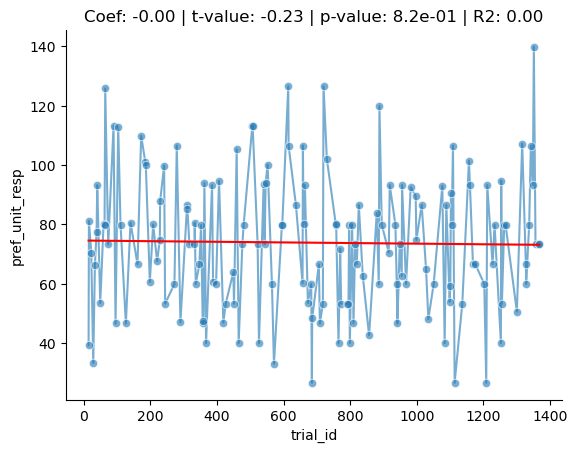

In [15]:
# examine the adaptation effect by linear model of resp vs trial_id as regression variable
sgtr_resp_df = pd.read_csv(join(figdir, f"single_trial_pref_unit_resp.csv"))
sns.lineplot(data=sgtr_resp_df.query(f"lin_dist == 0.0"), x="trial_id", y="pref_unit_resp", marker="o", alpha=0.6)
model = ols('pref_unit_resp ~ trial_id', data=sgtr_resp_df.query(f"lin_dist == 0.0")).fit()
print(model.summary())
# draw the model fit
sns.lineplot(x=sgtr_resp_df.query(f"lin_dist == 0.0")["trial_id"], y=model.fittedvalues, color="red")

# add a title to display the regression coef for trial_id and the tvalue and pvalue. R2
coef = model.params['trial_id']
tvalue = model.tvalues['trial_id']
pvalue = model.pvalues['trial_id']
r2 = model.rsquared
plt.title(f"Coef: {coef:.2f} | t-value: {tvalue:.2f} | p-value: {pvalue:.1e} | R2: {r2:.2f}")
plt.show()

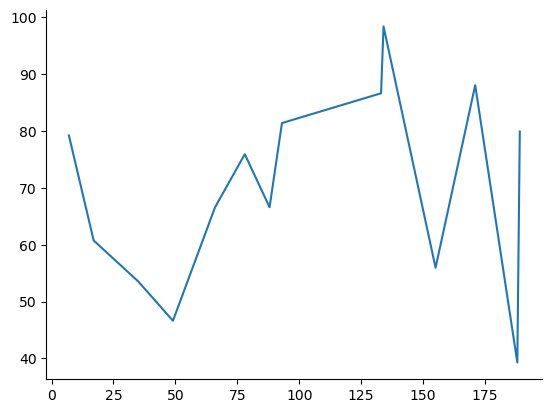

In [5]:
plt.plot(sgtr_resp_df.query(f"lin_dist == 0.0")["pref_unit_resp"])
plt.show()

In [3]:
sgtr_resp_per_space

,img_name,pref_unit_resp,space_name,eig_id,lin_dist,hessian_img
0,class_eig1_lin0.40,136.595154,class,1,0.40,True
1,class_eig1_lin0.24,137.118378,class,1,0.24,True
2,class_eig0_lin0.40,120.057068,class,0,0.40,True
4,class_eig1_lin-0.16,79.918022,class,1,-0.16,True
8,class_eig0_lin0.32,80.724617,class,0,0.32,True
10,class_eig0_lin-0.24,66.613129,class,0,-0.24,True
12,class_eig0_lin-0.32,114.635506,class,0,-0.32,True
14,class_eig1_lin-0.40,73.243462,class,1,-0.40,True
15,class_eig1_lin0.32,88.557976,class,1,0.32,True
16,class_eig0_lin0.16,80.602936,class,0,0.16,True
